In [1]:
# Loading training and test data

import torch
data_tr = torch.load("training-test-data/training_data.txt")
target_tr = torch.load("training-test-data/training_targets.txt")
data_test = torch.load("training-test-data/test_data.txt")
target_test = torch.load("training-test-data/test_targets.txt")

num_samples = 512 # number of training samples
num_samples_test = 100 # number of test samples
new_dim1 = 32 * 1 # first dimension
new_dim2 = 32 * 1 # second dimension
old_dim = 32 # CIFAR original dimension


In [11]:
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

# Two-layer linear convolutional neural network
output_channels = 1
class Net(nn.Module):
    def __init__(self, ker_size1, ker_size2, output_channels):
        super(Net, self).__init__()
        self.ker_size1 = ker_size1
        self.ker_size2 = ker_size2
        self.output_channels = output_channels
        self.conv1 = nn.Conv2d(3, output_channels, kernel_size=(self.ker_size1, self.ker_size2), bias=False) 
        self.fc1 = nn.Linear(int(new_dim1 * new_dim2 * output_channels), 1, bias=False)


    def forward(self, x):
        y1 = F.pad(x, (0,self.ker_size2-1,0,self.ker_size1-1), mode='circular') # Circular padding 
        y1 = self.conv1(y1)
        # y1 = F.relu(y1) # ReLU activations
        y1 = y1.reshape(y1.size(0), -1)
        y1 = self.fc1(y1) 
        return y1

    def initialize(self, initialization_scale, ker_size1):
        print("init")
        self.fc1.weight.data.mul_(initialization_scale)
        self.conv1.weight.data.mul_(initialization_scale)


output = torch.zeros((num_samples, 1))
output = output.float()
output_test = torch.zeros((num_samples_test, 1))
output_test = output.float()


# Batch gradient descent
def train_minibatch(network, optimizer):
    minibatch_size = 32
    num_batch = int(num_samples/minibatch_size)
    for i in range(num_batch):
        network.train()
        optimizer.zero_grad()
        start_index = i * minibatch_size
        end_index = start_index + minibatch_size
        output = network(data_tr[start_index:end_index])
        loss = torch.sum(torch.exp(-1 * torch.mul(output.flatten(), target_tr[start_index:end_index]))) / minibatch_size
        loss.backward()
        optimizer.step()

# Evaluate training data loss
def train_eval(network):
    network.eval()
    train_loss = 0
    correct = 0
    with torch.no_grad():
        output = network(data_tr)
        train_loss = torch.sum(torch.exp(-1 * torch.mul(output.flatten(), target_tr)))
        pred = output.apply_(lambda x: 1 if x > 0 else -1)
        correct += pred.eq(target_tr.data.view_as(pred)).sum()
    train_loss /= num_samples
    print('\nTrain set: Avg. loss: {:.9f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    train_loss, correct, num_samples,
    100. * correct / num_samples))
    return train_loss

def test(network):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        output_test = network(data_test)
        test_loss = torch.sum(torch.exp(-1 * torch.mul(output_test.flatten(), target_test)))
        pred = output_test.apply_(lambda x: 1 if x > 0 else -1)
        correct += pred.eq(target_test.data.view_as(pred)).sum()
    test_loss /= num_samples_test
    accuracy = 100. * correct / num_samples_test
    losses = test_loss
    return (accuracy, losses)

from matplotlib.colors import LogNorm


# Get the information about beta
def extract_info(network, show_photo): 

  # Compute beta for linear CNNs
    betas = []
    
    print("new")
  
  # Compute margin
    with torch.no_grad():
        network.eval()
        output_np = np.ndarray.flatten(network(data_tr).data.numpy())
        target_np = np.ndarray.flatten(target_tr.data.numpy())
        margins = [target_np[i] * output_np[i] for i in range(num_samples)]
        min_margin = min(margins) # get the minimum margin for any datapoint 
        
    for c in range(3):
        beta_test = np.zeros((new_dim1,new_dim2))
        for i in range(new_dim1):
            for j in range(new_dim2):
                tempimg = torch.zeros((1,3,new_dim1, new_dim2))
                tempimg[0,c,i,j]=1
                beta_test[i,j] = network(tempimg)  
        betas.append(beta_test / min_margin)

    # Compute R(beta)
    w1 = network.conv1.weight.detach().numpy()
    w2 = network.fc1.weight.detach().numpy()
    w1_norm_sq = np.sum(np.square(w1))
    w2_norm_sq = np.sum(np.square(w2))
    print(w1_norm_sq, w2_norm_sq)
    Rbeta = (np.sum(np.square(w1)) + np.sum(np.square(w2))) * np.sqrt(new_dim1 * new_dim2)
    Rbeta = Rbeta / min_margin

    print("Rbeta: " + str(Rbeta))

    if show_photo:
        sns.set_context("paper",font_scale=3,rc={"lines.linewidth":1})
        fig, axs = plt.subplots(2, 3, figsize=(20,10))
        for c in range(3):
            axs[0, c].imshow(np.absolute(betas[c]),cmap='gray')
            axs[1, c].imshow(np.absolute(np.fft.fft2(betas[c], norm='ortho')), cmap='gray', norm=LogNorm(vmin=0.0001, vmax=0.08))
        plt.show()
    return (Rbeta, betas)


In [12]:
# Train and extract info about beta
import seaborn as sns
n_epochs = 100000
momentum = 0.3
initialization_scale = 0.001

learning_rate_start = 0.005


from tqdm import tqdm_notebook as tqdm
def experiment(ker_size1, ker_size2, output_channels):
    network = Net(ker_size1, ker_size2, output_channels)
    network.initialize(initialization_scale, ker_size1)
    optimizer =  optim.SGD(network.parameters(), lr=learning_rate_start, momentum=momentum)
    print("Before training:")
    train_eval(network)
    print("Start training:")
    for epoch in tqdm(range(1, n_epochs + 1)):
        train_minibatch(network, optimizer)
        if epoch % 100 == 0:
            loss = train_eval(network)
            if loss <= 0.000001: # stop at 10^-6 loss 
                break

        if epoch % 1000 == 0:
            print(test(network))

        if epoch == 200 == 0:
            optimizer =  optim.SGD(network.parameters(), lr=0.01, momentum=momentum)

        if epoch == 500:
            optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=momentum)

        if epoch == 1000:
            optimizer = optim.SGD(network.parameters(), lr=0.05, momentum=momentum)

        if epoch == 1200:
            optimizer = optim.SGD(network.parameters(), lr=0.1, momentum=momentum)

        if epoch == 1500:
            optimizer = optim.SGD(network.parameters(), lr=0.5, momentum=momentum)

        if epoch == 2000:
            optimizer = optim.SGD(network.parameters(), lr=1, momentum=momentum)

        if epoch == 3000:
            optimizer = optim.SGD(network.parameters(), lr=2, momentum=momentum)

        if epoch == 4000:
            optimizer = optim.SGD(network.parameters(), lr=4, momentum=momentum)

        if epoch == 4500:
            optimizer = optim.SGD(network.parameters(), lr=10, momentum=momentum)

        if epoch == 5000:
            optimizer = optim.SGD(network.parameters(), lr=20, momentum=momentum)




    print("After training:")
    train_eval(network)
    (accuracy, losses) = test(network)
    print(accuracy, losses)

    (rk, beta) = extract_info(network, True)
    return (rk, beta)


In [13]:


import pandas as pd
        

Cout = [1, 2, 3, 4, 8]


def run_experiment_series(k):
    pairs = []
    for c in Cout:
        pairs.append((k, c))
    betas = []
    rbetas = []
    for (k, output_channels) in pairs:
        print(k, output_channels)
        (Rbeta, beta) = experiment(k, k, output_channels)
        rbetas.append(Rbeta)
        betas.append(beta)

    # Write betas
    for i in range(len(pairs)):
        rbetas_to_write = []
        index = i
        rbetas_to_write.append(rbetas[index])
        beta_array = betas[index]
        for j in range(3):
            beta = beta_array[j]
            name = "experiments-data/" + "beta" + str(pairs[i]) + "inputchannel" + str(j) + ".csv"
            print(str(pairs[i]))
            pd.DataFrame(beta).to_csv(name, header=False, index=False)
        name = "experiments-data/" + "rbetas" + str(pairs[i]) + "inputchannel" + ".csv"
        pd.DataFrame(rbetas_to_write).to_csv(name, header=False, index=False)
    

20 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 300/512 (59%)

Start training:


<ipython-input-12-7856f034cddc>:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(1, n_epochs + 1)):


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.113895565, Accuracy: 509/512 (99%)


Train set: Avg. loss: 0.025383567, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012153758, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.007546170, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005319965, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003206406, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002235669, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001692460, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001349587, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001115381, Accuracy: 512/512 (100%)

(tensor(68.), tensor(9.2030e+11))

Train set: Avg. loss: 0.000567174, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000370499, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000211677, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000145650, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000110070, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000046570, A

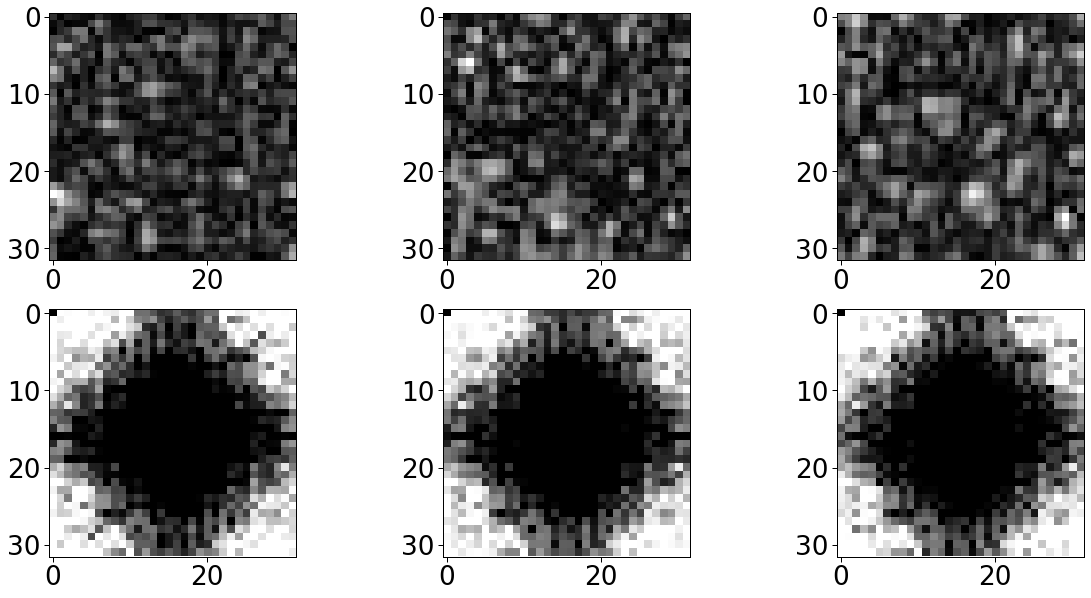

(20, 3)
(20, 3)
(20, 3)
32 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 232/512 (45%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.371342719, Accuracy: 479/512 (94%)


Train set: Avg. loss: 0.025484797, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.011243817, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.006875360, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004835492, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002926824, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002035495, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001542505, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001232414, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001020683, Accuracy: 512/512 (100%)

(tensor(70.), tensor(2.5963e+09))

Train set: Avg. loss: 0.000520084, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000336448, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000192542, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000131870, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000099721, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000041900, A

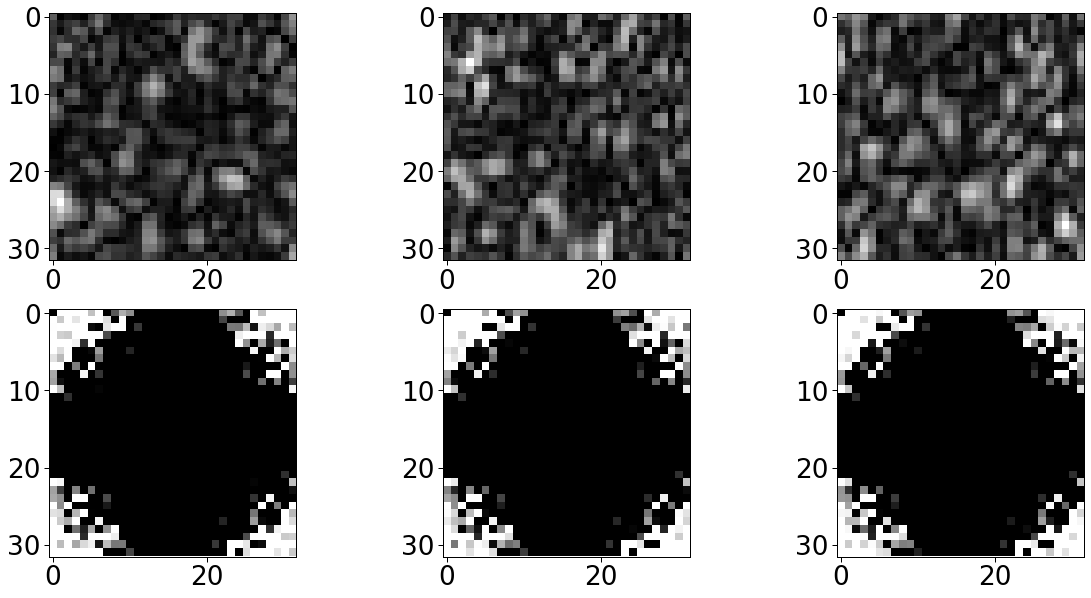

(32, 3)
(32, 3)
(32, 3)


In [18]:
k_vals = [1, 3, 8, 20, 32]
for k in k_vals:
    run_experiment_series(k)